<a href="https://colab.research.google.com/github/arfianaja/yolov5_train/blob/main/skripsi_hasil_yolan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/catto.zip'

Archive:  /content/drive/MyDrive/catto.zip
   creating: catto/
   creating: catto/kucing sakit/
  inflating: catto/kucing sakit/ksakit (1).jpg  
  inflating: catto/kucing sakit/ksakit (10).jpg  
  inflating: catto/kucing sakit/ksakit (11).jpg  
  inflating: catto/kucing sakit/ksakit (12).jpg  
  inflating: catto/kucing sakit/ksakit (13).jpg  
  inflating: catto/kucing sakit/ksakit (14).jpg  
  inflating: catto/kucing sakit/ksakit (15).jpg  
  inflating: catto/kucing sakit/ksakit (16).jpg  
  inflating: catto/kucing sakit/ksakit (17).jpg  
  inflating: catto/kucing sakit/ksakit (18).jpg  
  inflating: catto/kucing sakit/ksakit (19).jpg  
  inflating: catto/kucing sakit/ksakit (2).jpg  
  inflating: catto/kucing sakit/ksakit (20).jpg  
  inflating: catto/kucing sakit/ksakit (21).jpg  
  inflating: catto/kucing sakit/ksakit (22).jpg  
  inflating: catto/kucing sakit/ksakit (23).jpg  
  inflating: catto/kucing sakit/ksakit (24).jpg  
  inflating: catto/kucing sakit/ksakit (25).jpg  
  infl

In [5]:
base_dir = '/content/kucing'

In [7]:
sdir=r'/content/catto'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths        labels
0  /content/catto/kucing sakit/kucing sakit (267)...  kucing sakit
1  /content/catto/kucing sakit/kucing sakit (27).jpg  kucing sakit
2  /content/catto/kucing sakit/kucing sakit (412)...  kucing sakit
3  /content/catto/kucing sakit/kucing sakit (363)...  kucing sakit
4  /content/catto/kucing sakit/kucing sakit (25).jpg  kucing sakit
kucing sehat    1192
kucing sakit     480
Name: labels, dtype: int64


In [8]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1337   test_df length:  167   valid_df length:  168


In [9]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  1   test steps:  167
Found 1337 validated image filenames belonging to 2 classes.
Found 168 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
['kucing sakit', 'kucing sehat']


In [10]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

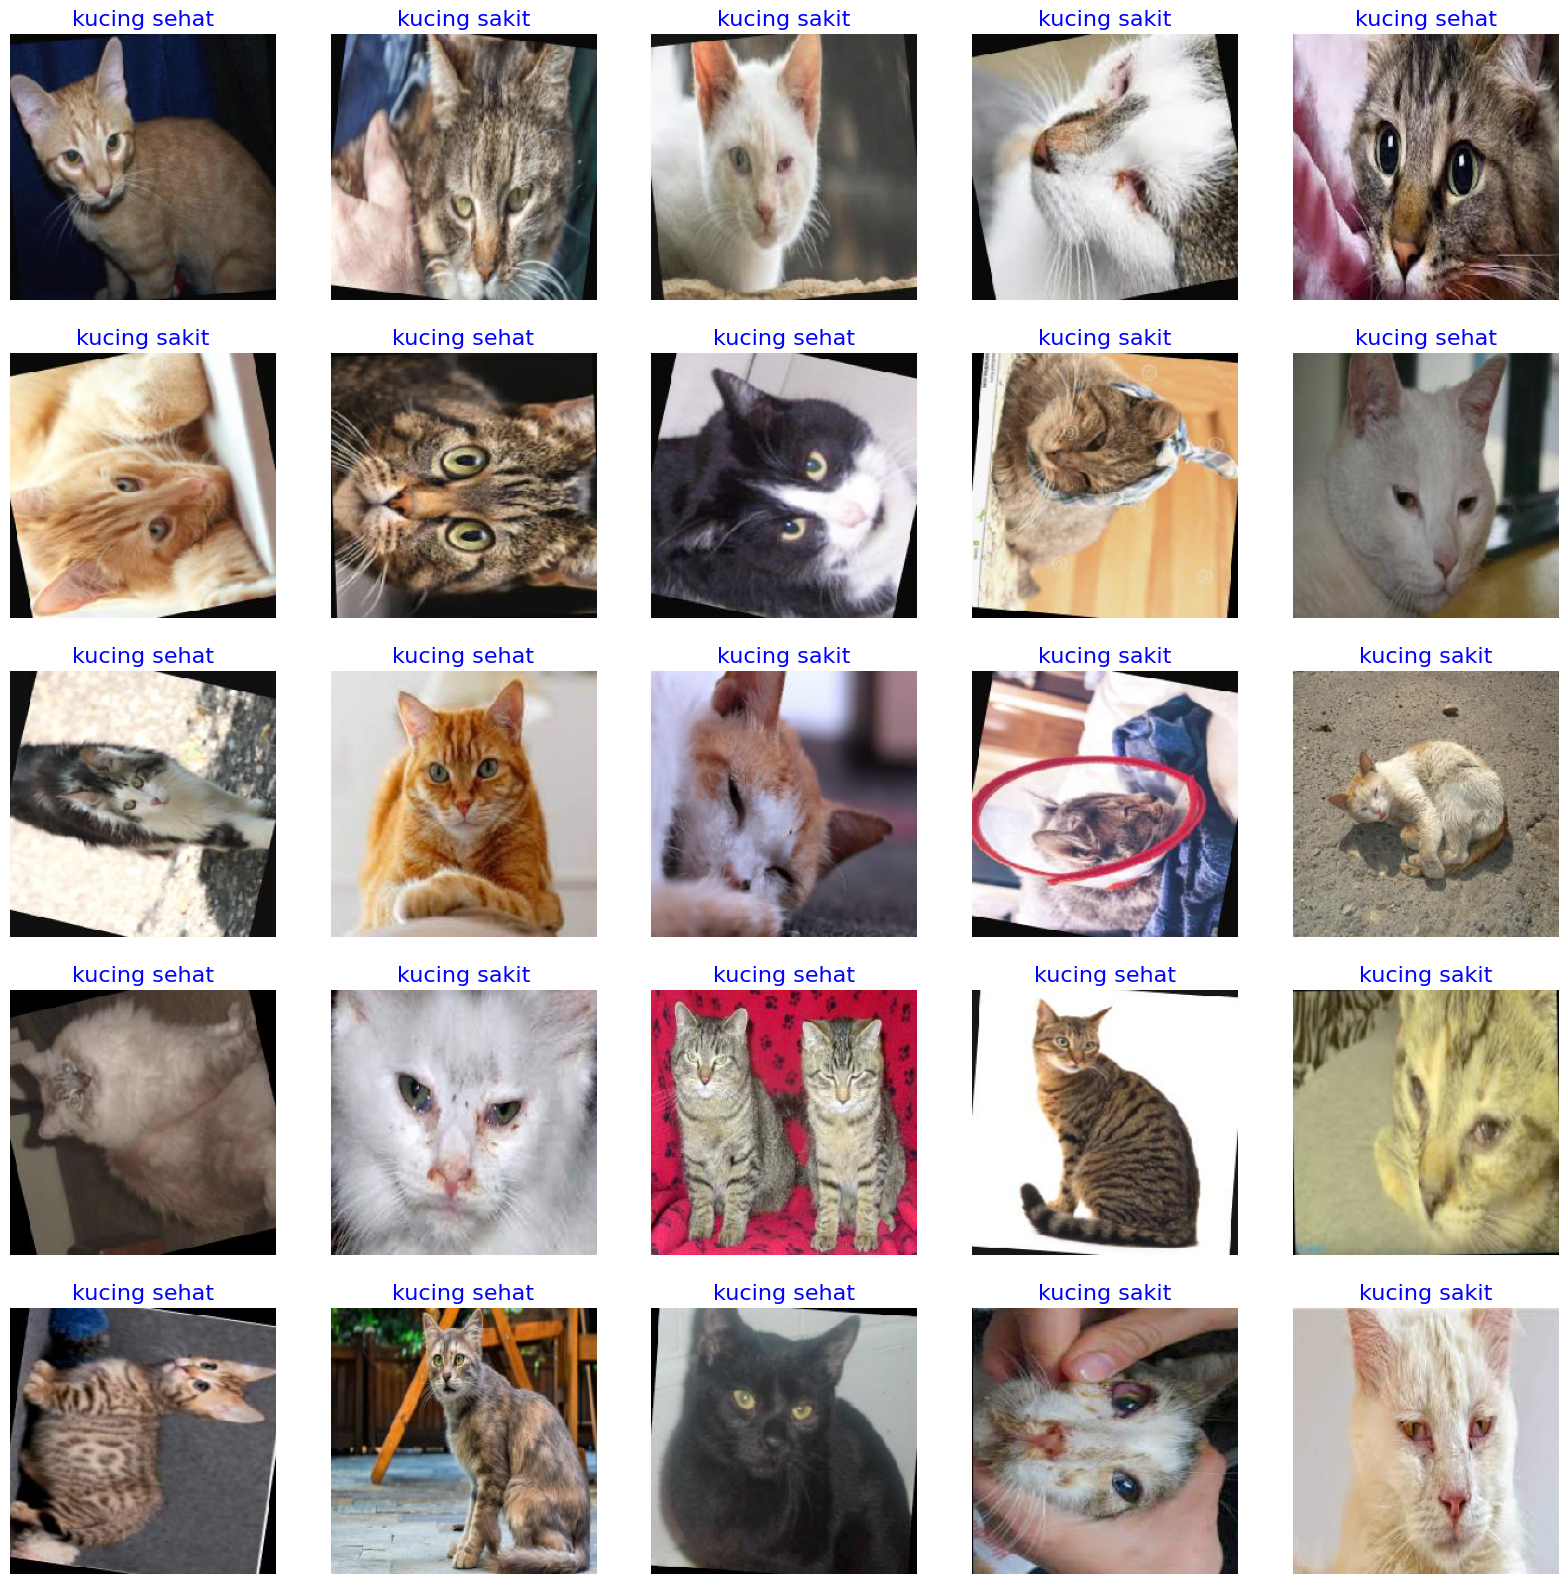

In [11]:
show_image_samples(train_gen)

In [12]:
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_tensor=Input(shape=(128,128,3)))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [14]:
base_model.trainable = False

In [15]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x7f7126ab2ef0>


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                        

In [6]:
import os
import pandas as pd
base_dir='/content/kucing'

filepaths=[]
labels=[]
classlist=os.listdir(base_dir)
for klass in classlist:
    classpath=os.path.join(base_dir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

FileNotFoundError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1166   test_df length:  146   valid_df length:  146


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Periksa versi library TensorFlow & Keras
print("Versi TensorFlow :", tf.__version__)
print("Versi Keras      :", keras.__version__)

Versi TensorFlow : 2.12.0
Versi Keras      : 2.12.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
height=128
width=128
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  73   test steps:  2
Found 1166 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.
['KucingSakit', 'KucingSehat']


In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

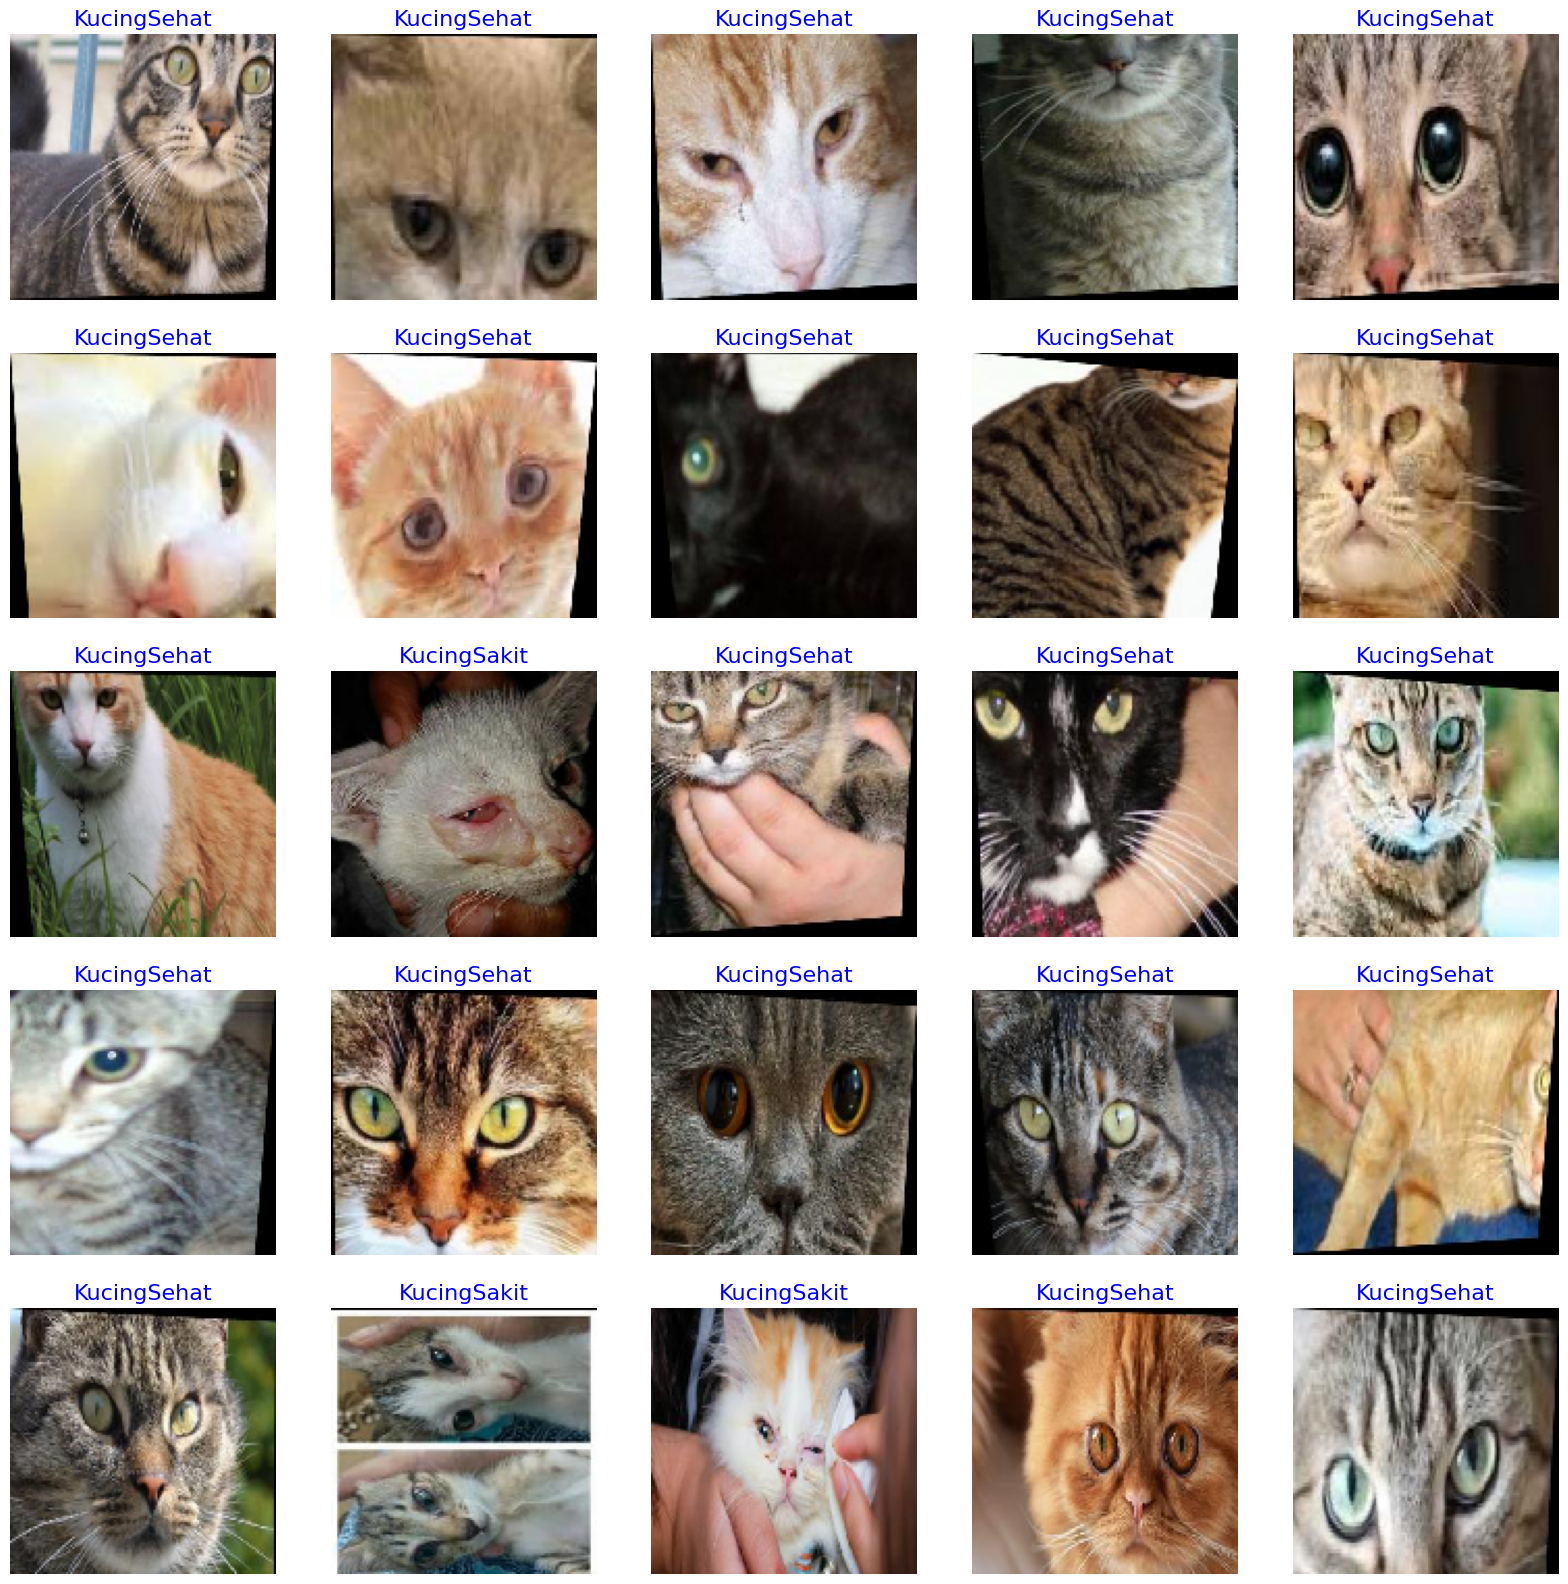

In [ ]:
show_image_samples(train_gen)

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_tensor=Input(shape=(128,128,3)))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
base_model.trainable = False

In [ ]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x7ff2c3266a10>


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                        

In [ ]:
epochs =10

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/10
19/19 [==============================] - 17s 273ms/step - loss: 0.5705 - accuracy: 0.7607 - val_loss: 0.2441 - val_accuracy: 0.9110
Epoch 2/10
19/19 [==============================] - 3s 136ms/step - loss: 0.2052 - accuracy: 0.9254 - val_loss: 0.1574 - val_accuracy: 0.9315
Epoch 3/10
19/19 [==============================] - 3s 134ms/step - loss: 0.1450 - accuracy: 0.9400 - val_loss: 0.1234 - val_accuracy: 0.9452
Epoch 4/10
19/19 [==============================] - 3s 136ms/step - loss: 0.1105 - accuracy: 0.9631 - val_loss: 0.1044 - val_accuracy: 0.9589
Epoch 5/10
19/19 [==============================] - 3s 136ms/step - loss: 0.0854 - accuracy: 0.9700 - val_loss: 0.1036 - val_accuracy: 0.9521
Epoch 6/10
19/19 [==============================] - 3s 137ms/step - loss: 0.0603 - accuracy: 0.9811 - val_loss: 0.0838 - val_accuracy: 0.9589
Epoch 7/10
19/19 [==============================] - 3s 135ms/step - loss: 0.0520 - accuracy: 0.9854 - val_loss: 0.0728 - val_accuracy: 0.9726
Epoch

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

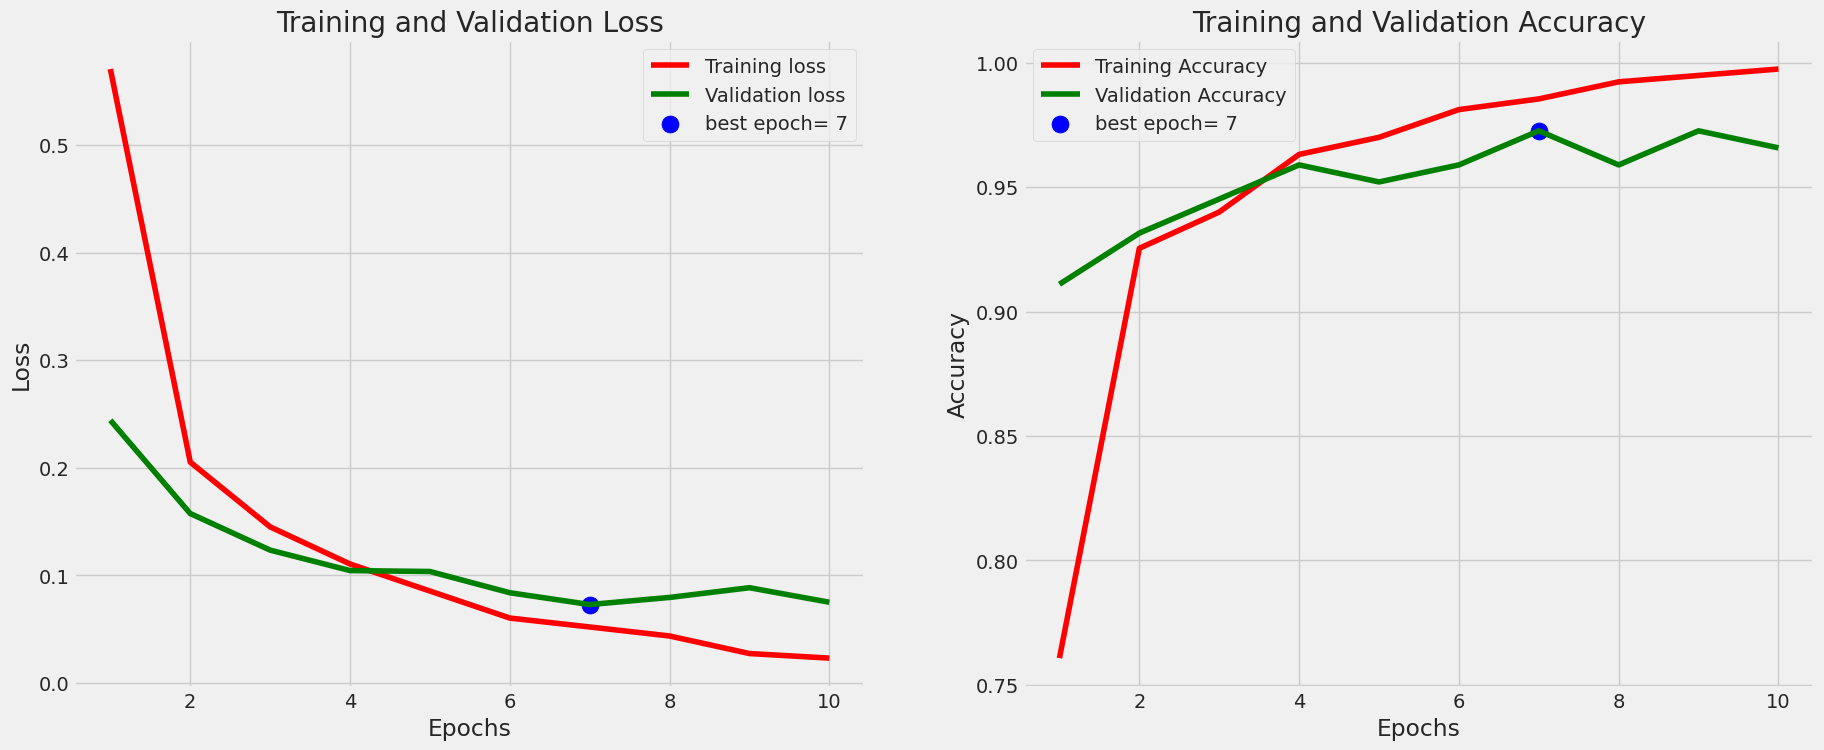

2/2 [==============================] - 0s 169ms/step - loss: 0.0865 - accuracy: 0.9658
accuracy on the test set is 96.58 %



In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='Data_kucing'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

2/2 [==============================] - 0s 134ms/step


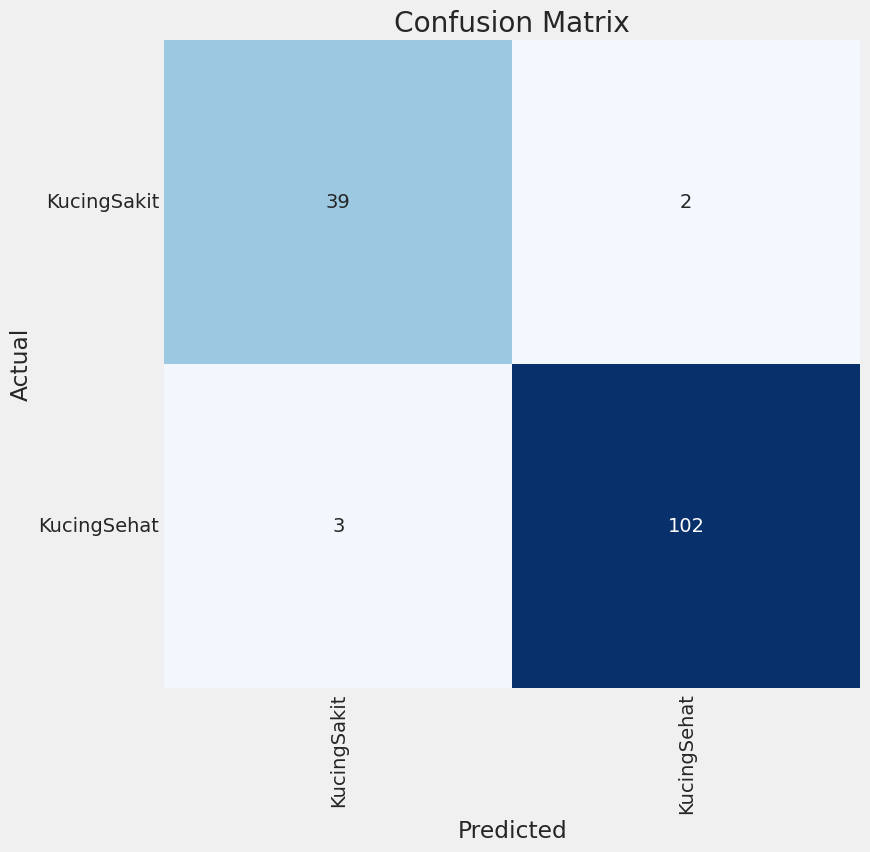

Classification Report:
----------------------
               precision    recall  f1-score   support

 KucingSakit       0.93      0.95      0.94        41
 KucingSehat       0.98      0.97      0.98       105

    accuracy                           0.97       146
   macro avg       0.95      0.96      0.96       146
weighted avg       0.97      0.97      0.97       146



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )